# This notebook was created to show the entire workflow of CNN training

### The config file contains all parameters needed to initialise and train the model. 

### Currently only VGG16 and ResNet101 are implemented

Loading the config parameters:

In [1]:
import configparser
import json

config = configparser.ConfigParser()
config.read("config.ini")

for section in config.sections():
    print(f"[{section}]")
    for key, value in config[section].items():
        print(f"{key} = {value}")
    print() 

dataset_path = str(config["DATASET"]["path"])
mean = json.loads(config["DATASET"]["mean"])
std = json.loads(config["DATASET"]["std"])
train_size = float(config["DATASET"]["train_size"])
test_size = float(config["DATASET"]["test_size"])

model_name = str(config["MODEL"]["model_name"])
version = int(config["MODEL"]["version"])
epochs = int(config["MODEL"]["epochs"])
batch_size = int(config["MODEL"]["batch_size"])
weighting = json.loads(config["MODEL"]["weighting"])
learning_rate = float(config["MODEL"]["learning_rate"])

[DATASET]
path = ../new_methodology/training_images
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
train_size = 0.01
test_size = 0.98

[MODEL]
model_name = VGG16
version = 1
epochs = 1
batch_size = 64
weighting = [0.5, 0.5]
learning_rate = 0.001



Loading dataset:

In [ ]:
import models

dataloaders = models.load_dataset(dataset_path, mean, std, batch_size, train_size, test_size)

"dataloaders" is a dictionary with three dataloaders for train, val, and test phases.

We can inspect what kind of images are present in the dataset, what are the sizes of train, val, and test datasets.

In [ ]:
print("Dataset sizes:")
print(f"Training set: {len(dataloaders['train'].dataset)} images")
print(f"Validation set: {len(dataloaders['val'].dataset)} images")
print(f"Testing set: {len(dataloaders['test'].dataset)} images")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, mean, std):
    img = img.numpy().transpose((1, 2, 0)) 
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

def show_sample_images(dataloaders, mean, std, num_images=6):
    mean = np.array(mean)
    std = np.array(std)
    images_shown = 0

    dataiter = iter(dataloaders['test'])
    images, labels = next(dataiter)

    plt.figure(figsize=(num_images*2, num_images))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        imshow(images[i], mean, std)
        plt.title(f"Label: {labels[i].item()}")
        images_shown += 1
    plt.tight_layout()
    plt.show()

show_sample_images(dataloaders, mean, std, num_images=6)

Loading the model:

In [ ]:
model, optimizer, decay_learning_rate, loss_function, device = models.get_model(model_name, learning_rate, weighting)

Training the model:

In [ ]:
model = models.train_model(model = model, 
                           optimizer = optimizer, 
                           scheduler = decay_learning_rate, 
                           loss_function = loss_function, 
                           device = device, 
                           dataloaders = dataloaders,
                           num_epochs = epochs, 
                           patience = 1)

Testing the model performance:

In [ ]:
test_data = models.test_model(model, dataloaders, device, loss_function)

Saving the model:

In [ ]:
models.save_model(model, model_name, version)

Loading the trained model for future use:

You can either load the model by specifying a path to the pth file

In [ ]:
import torch
model = torch.load("ResNet101/v1/best_model_2025-04-21_11-20-00.pth")

Or by loading the latest available model given model name and version

In [ ]:
import models
model = models.load_latest_model("VGG16", version = 1, device = "cpu")

Finally, we can use the trained models to make predictions on a new image:

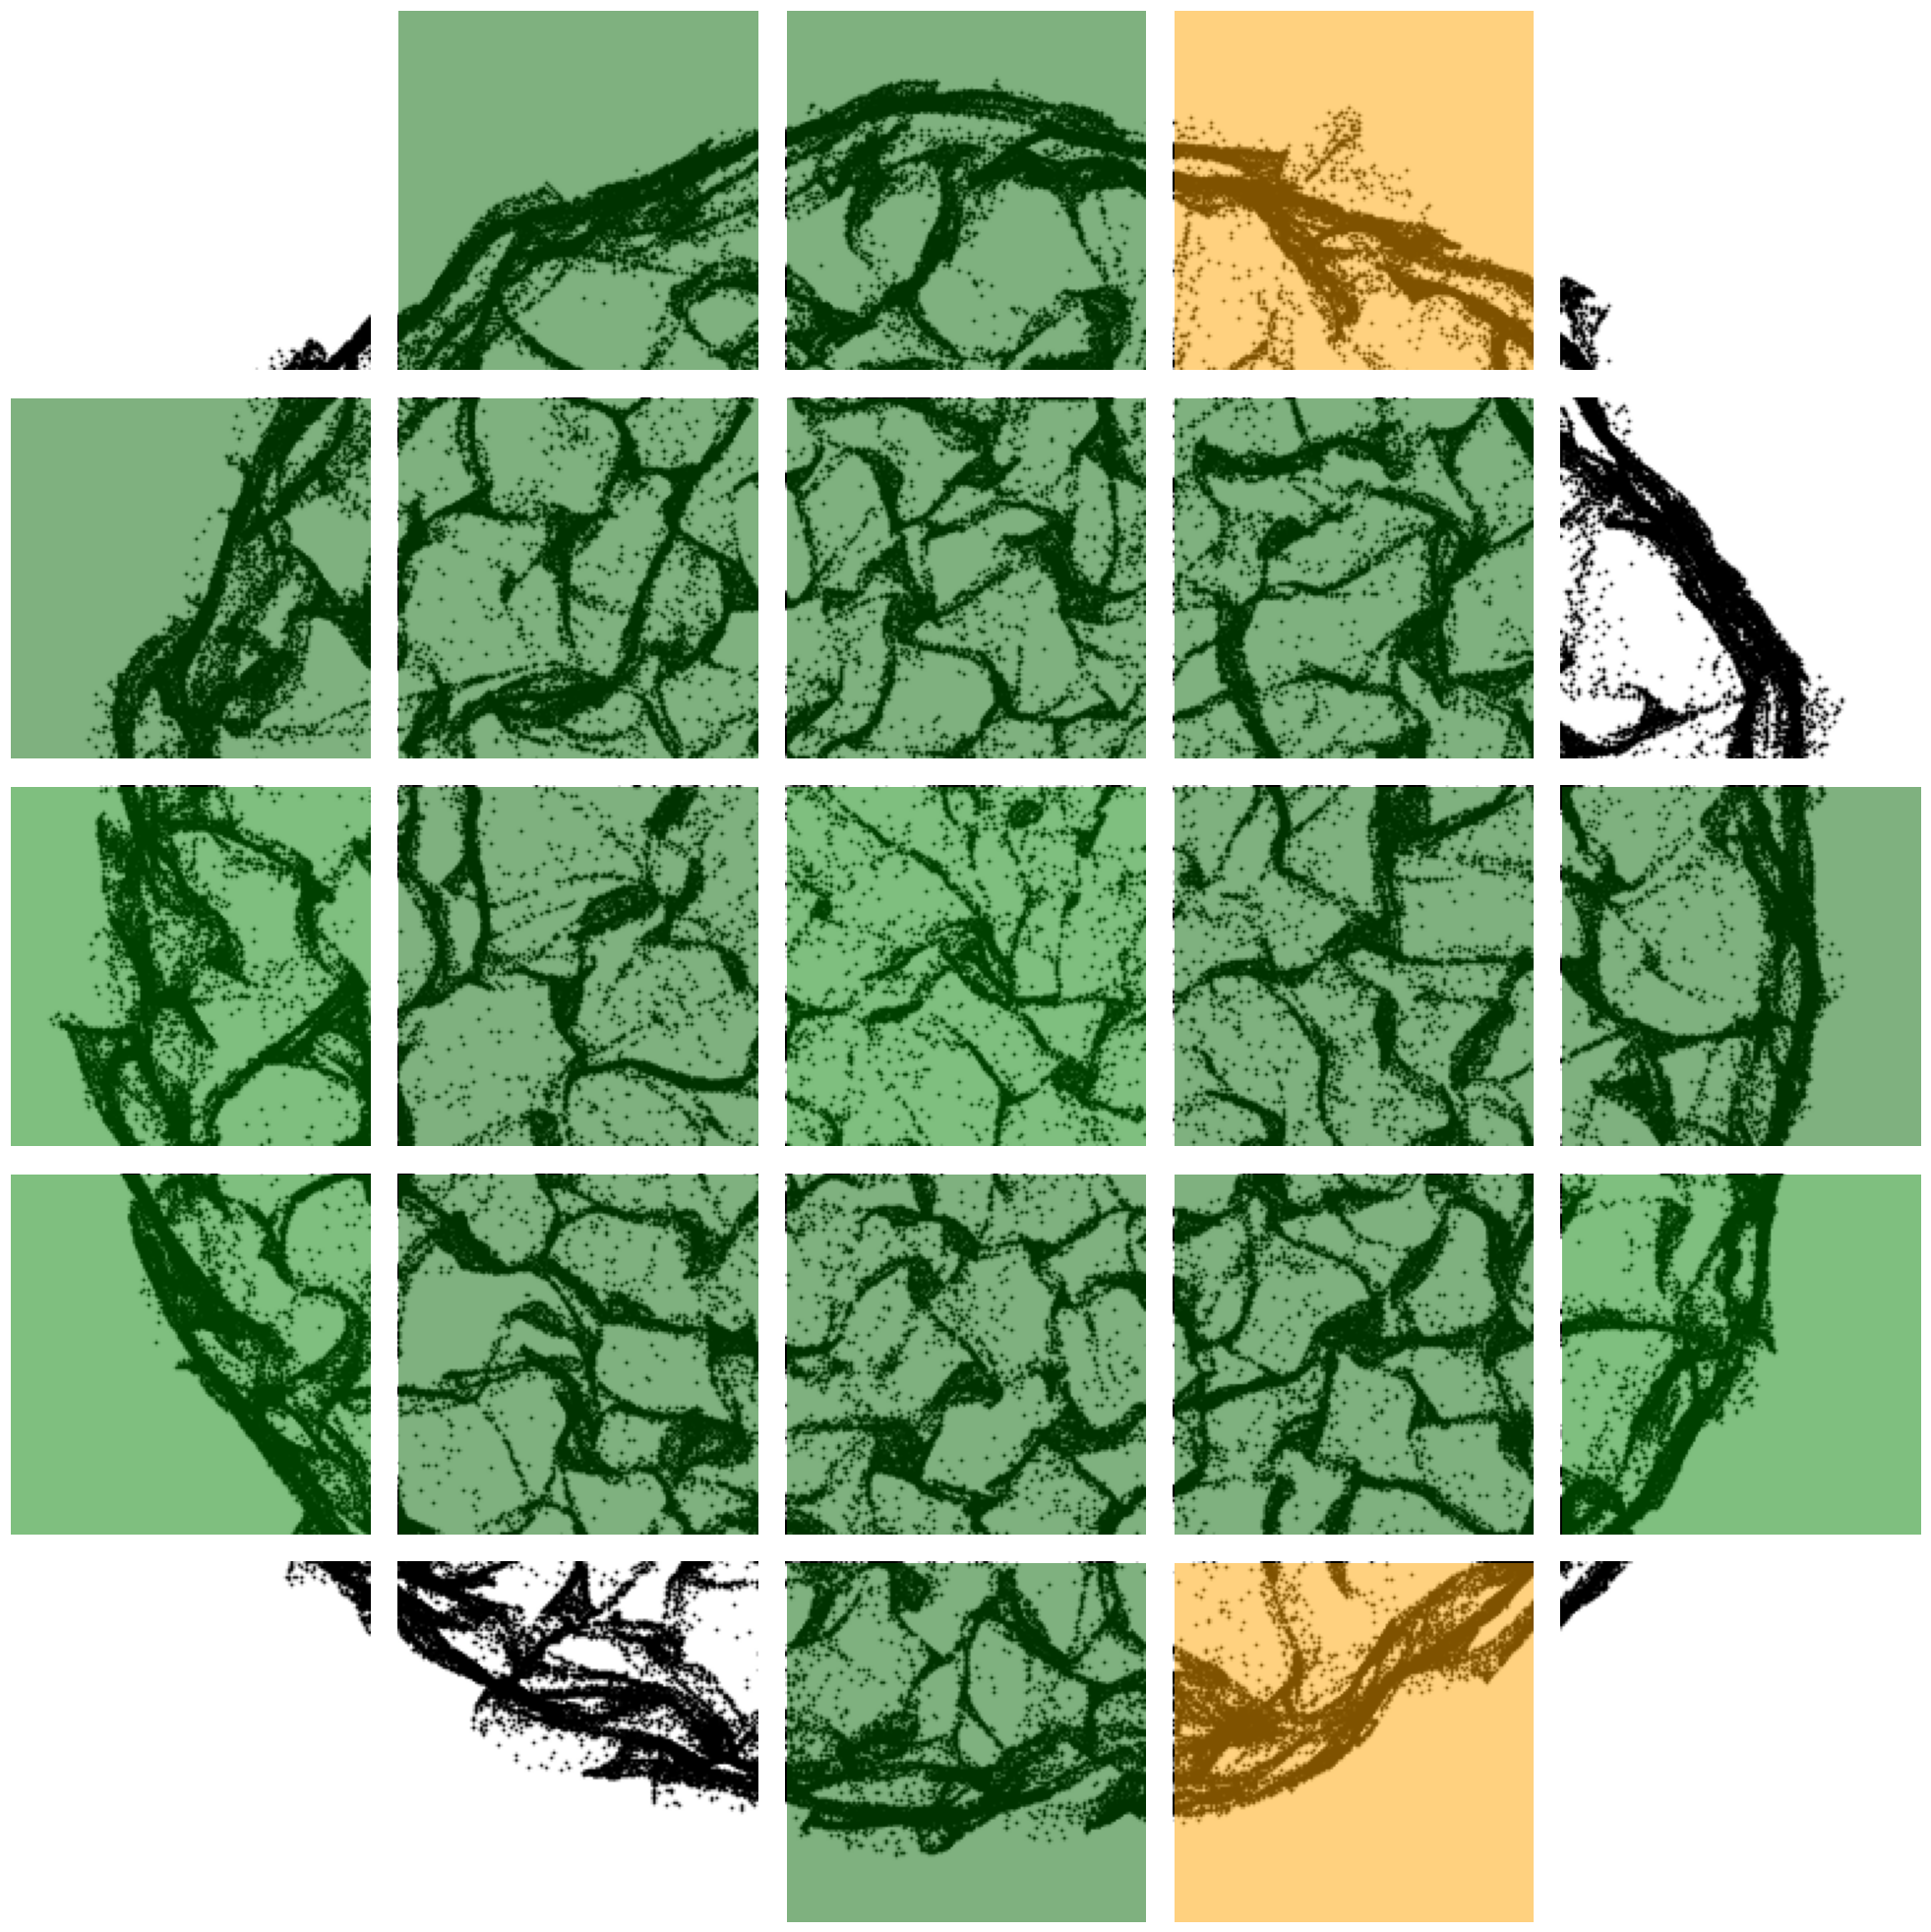

In [2]:
import torch
import models
#loading the best model from a different directory 
best_model_path = '../new_methodology/vgg_models/v1/COS_vg_best_model.pth'
model = torch.load(best_model_path)
image_path = './images/rigid.png'
confidences = models.get_prediction(model, image_path, 5, mean, std)


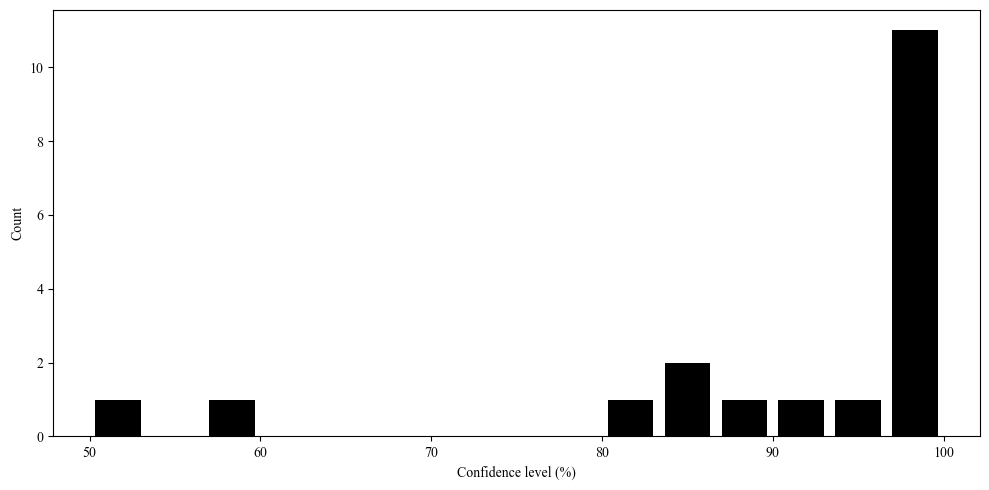

In [3]:
models.plot_histogram(confidences)